# Install required libraries

In [1]:
!pip install numpy rasterio scikit-learn matplotlib


     ---------------------------------------- 24.3/24.3 MB 2.5 MB/s eta 0:00:00
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Preparation

In [6]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Define function to replace NA/NaN/Inf with a specific value
def replace_invalid(array, value=0):
    array[np.isnan(array)] = value
    array[np.isinf(array)] = value
    return array

# Function to load and resample rasters
def load_and_resample_raster(file_path, reference_meta):
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)  # Read with masking
        data = replace_invalid(data)
        data_resampled = src.read(
            out_shape=(reference_meta['height'], reference_meta['width']),
            resampling=Resampling.nearest
        )
        return data_resampled.squeeze()  # Remove singleton dimension

# Load reference raster (NDVI)
with rasterio.open("E:/CLIENTS/Precision farming/processed/NDVI_2023_January.tif") as src:
    ndvi = replace_invalid(src.read(1, masked=True))
    ndvi_meta = src.meta

# Load and resample other rasters
gndvi = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/GNDVI_2023_January.tif", ndvi_meta)
dem = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/DEM_2023_January.tif", ndvi_meta)
soc = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/SOC_2023_January.tif", ndvi_meta)
sand = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/Sand_2023_January.tif", ndvi_meta)
clay = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/Clay_2023_January.tif", ndvi_meta)
moisture = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/moistureclipped.tif", ndvi_meta)
wetmass = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/wetmass clipped.tif", ndvi_meta)
yield_ = load_and_resample_raster("E:/CLIENTS/Precision farming/processed/yieldclipped.tif", ndvi_meta)

# Verify dimensions of all rasters
print("NDVI shape:", ndvi.shape)
print("GNDVI shape:", gndvi.shape)
print("DEM shape:", dem.shape)
print("SOC shape:", soc.shape)
print("Sand shape:", sand.shape)
print("Clay shape:", clay.shape)
print("Moisture shape:", moisture.shape)
print("Wetmass shape:", wetmass.shape)
print("Yield shape:", yield_.shape)

# Stack layers for clustering
stacked_data = np.dstack((ndvi, gndvi, dem, soc, sand, clay, moisture, wetmass, yield_))


NDVI shape: (1285, 898)
GNDVI shape: (1285, 898)
DEM shape: (1285, 898)
SOC shape: (1285, 898)
Sand shape: (1285, 898)
Clay shape: (1285, 898)
Moisture shape: (1285, 898)
Wetmass shape: (1285, 898)
Yield shape: (1285, 898)


# Clustering analysis

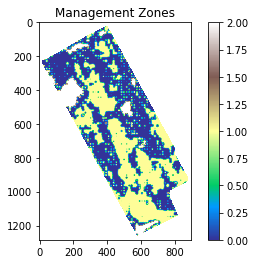

C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\696796922.py:29: RuntimeWarning: invalid value encountered in cast
  clustered_raster = clustered_raster.astype(np.int32)  # Convert to int


In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Reshape the data for clustering
rows, cols, n_bands = stacked_data.shape
stacked_data_reshaped = stacked_data.reshape(rows * cols, n_bands)

# Remove invalid data
valid_data_mask = ~np.isnan(stacked_data_reshaped).any(axis=1)
valid_data = stacked_data_reshaped[valid_data_mask]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=123).fit(valid_data)

# Create a raster for clusters
clustered_data = np.full(stacked_data_reshaped.shape[0], np.nan)
clustered_data[valid_data_mask] = kmeans.labels_

# Reshape back to the original shape
clustered_raster = clustered_data.reshape(rows, cols)

# Visualize Clusters
plt.imshow(clustered_raster, cmap='terrain')
plt.colorbar()
plt.title("Management Zones")
plt.show()

# Export Results using rasterio
clustered_raster = clustered_raster.astype(np.int32)  # Convert to int
with rasterio.open(
    "E:/CLIENTS/Precision farming/processed/ManagementZones22.tif", 
    'w', 
    driver='GTiff', 
    height=ndvi_meta['height'], 
    width=ndvi_meta['width'], 
    count=1, 
    dtype=np.int32, 
    crs=ndvi_meta['crs'], 
    transform=ndvi_meta['transform']
) as dst:
    dst.write(clustered_raster, 1)


# Classified Management zones

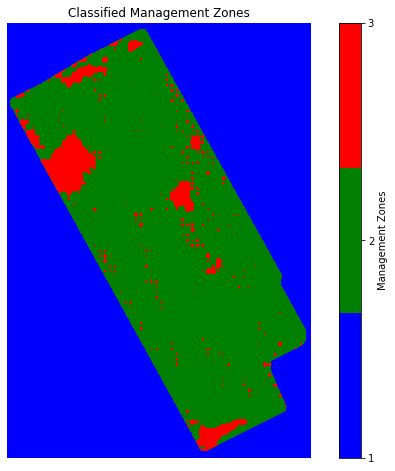

Classified Management Zones exported to: E:/CLIENTS/Precision farming/processed/ClassifiedManagementZones_new.tif


In [8]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Function to classify management zones
def classify_management_zones(raster):
    # Define class intervals
    classes = np.zeros_like(raster, dtype=np.uint8)
    classes[raster <= -1] = 1  # Class 1
    classes[(raster > -1) & (raster <= 1)] = 2  # Class 2
    classes[raster > 1] = 3  # Class 3
    return classes

# Load management zones raster
management_zones_file = "E:/CLIENTS/Precision farming/processed/ManagementZones22.tif"
with rasterio.open(management_zones_file) as src:
    management_zones = src.read(1)

# Classify management zones
classified_zones = classify_management_zones(management_zones)

# Visualize the classified raster
plt.figure(figsize=(10, 8))
cmap = ListedColormap(['blue', 'green', 'red'])  # Define colors for each class
plt.imshow(classified_zones, cmap=cmap, vmin=1, vmax=3)  # Adjust vmin and vmax to match your class intervals
plt.colorbar(ticks=[1, 2, 3], label='Management Zones')
plt.title('Classified Management Zones')
plt.axis('off')
plt.show()

# Export the classified raster
output_file = "E:/CLIENTS/Precision farming/processed/ClassifiedManagementZones_new.tif"
with rasterio.open(management_zones_file) as src:
    profile = src.profile  # Use the profile of the original raster
    profile.update(dtype=rasterio.uint8, count=1)  # Update profile for the classified raster
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(classified_zones, 1)

print(f"Classified Management Zones exported to: {output_file}")


# Nitrogen fertilization (VRA)

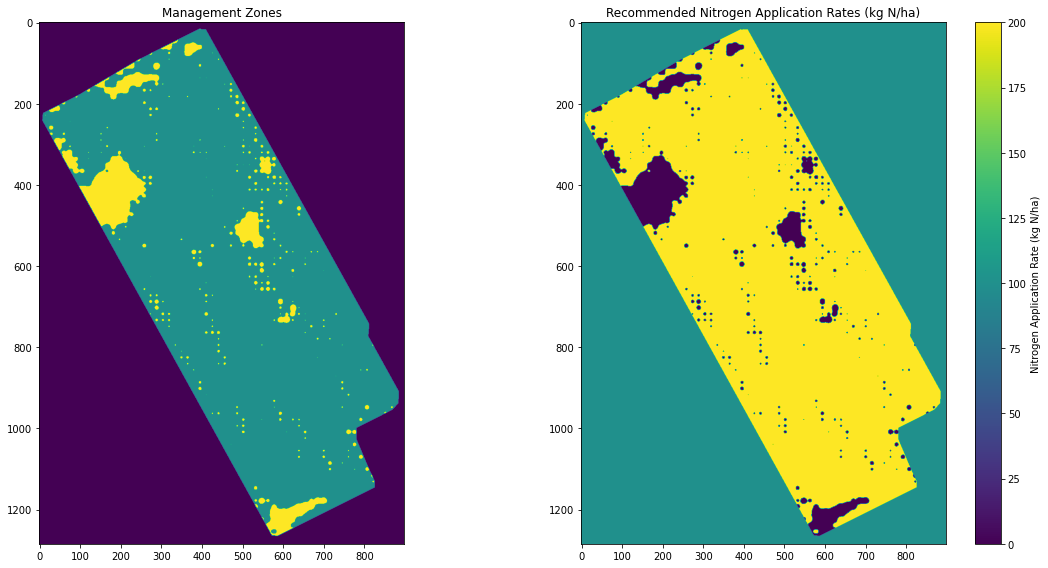

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Function to assign nitrogen application rates based on classified zones
def assign_nitrogen_rates(classified_zones):
    nitrogen_rates = np.zeros_like(classified_zones, dtype=np.float32)
    # Assign rates based on classified zones
    # Low Vigor (Orange Zone)
    nitrogen_rates[classified_zones == 1] = 100  # Example: 100 kg N/ha
    # High Vigor (Green Zone)
    nitrogen_rates[classified_zones == 2] = 200  # Example: 200 kg N/ha
    return nitrogen_rates

# Load classified management zones raster
classified_zones_file = "E:/CLIENTS/Precision farming/processed/ClassifiedManagementZones_new.tif"
with rasterio.open(classified_zones_file) as src:
    classified_zones = src.read(1)
    profile = src.profile  # Get profile of the input raster

# Assign nitrogen application rates
nitrogen_application_rates = assign_nitrogen_rates(classified_zones)

# Export nitrogen application rates as a new raster (optional)
output_nitrogen_rates_file = "E:/CLIENTS/Precision farming/processed/NitrogenApplicationRates.tif"
with rasterio.open(output_nitrogen_rates_file, 'w', **profile) as dst:
    dst.write(nitrogen_application_rates, 1)

# Visualize the nitrogen application rates and management zones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot management zones
ax1.set_title("Management Zones")
show(classified_zones, ax=ax1, cmap='viridis')

# Plot nitrogen application rates
cbar = ax2.imshow(nitrogen_application_rates, cmap='viridis')
ax2.set_title("Recommended Nitrogen Application Rates (kg N/ha)")
fig.colorbar(cbar, ax=ax2, label='Nitrogen Application Rate (kg N/ha)')

# Show plot in Jupyter Notebook
plt.tight_layout()
plt.show()
